<a href="https://colab.research.google.com/github/Pavel184/Machine_vision/blob/Homework_lesson_6/Homework_lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение эмбеддингов (Metric Learning)
Данные, необходимые для этого модуля:
* symbol_a1.png
* symbol_a2.png
* symbol_b1.png

## Переключение версии TensorFlow

In [65]:
%tensorflow_version 2.x

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf

In [67]:
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [68]:
tfds.disable_progress_bar()
(train_ds), ds_info = tfds.load(
    'LFW', 
    as_supervised=True,
    with_info=True
)

In [69]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [70]:
train_ds = train_ds.get('train')

## Визуализация датасета LFW

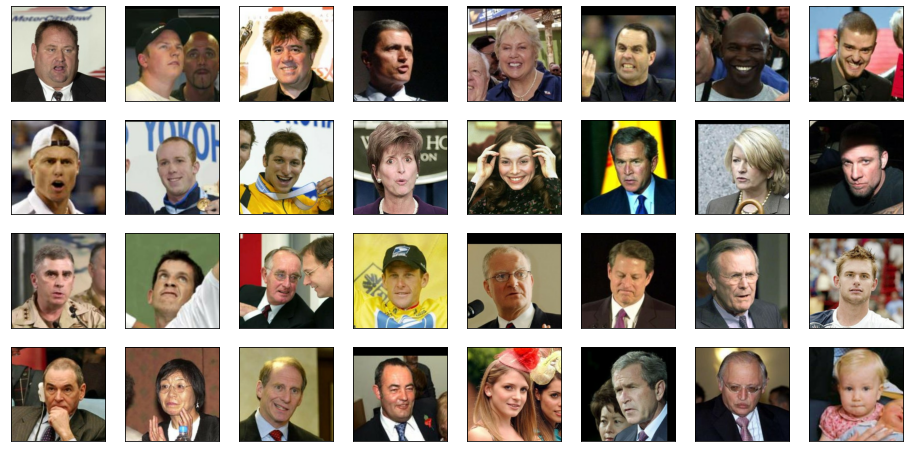

In [71]:
some_samples = [x[1] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [72]:
EMB_SIZE = 256

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [73]:
MARGIN = 20.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)*2
    d =  tf.sqrt(d2)*2
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [74]:
BATCH_SIZE = 64
NUM_EPOCHS = 60
def prepare(label, img):
    img = tf.cast(img, tf.float32)/127. - 1.
    return img, label

def prep_test(img, label):
    return img

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

## Подготовка к обучению

In [75]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [76]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
       
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if loss_value > 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

Streaming output truncated to the last 5000 lines.
[719] Loss: 0.19096998870372772
[720] Loss: 4.177077293395996
[721] Loss: 0.024726256728172302
[722] Loss: 0.08265110850334167
[723] Loss: 13.969740867614746
[724] Loss: 6.015566825866699
[726] Loss: 5.339615821838379
[730] Loss: 0.0019240869442000985
[731] Loss: 0.03288298100233078
[732] Loss: 0.33274975419044495
[733] Loss: 0.010003097355365753
[734] Loss: 0.31548523902893066
[735] Loss: 0.24281266331672668
[736] Loss: 0.0075546675361692905
[737] Loss: 0.2066485583782196
[738] Loss: 0.0018759985687211156
[739] Loss: 2.254533052444458
[742] Loss: 3.945645809173584
[743] Loss: 0.09368570148944855
[744] Loss: 0.43421170115470886
[747] Loss: 0.07106660306453705
[751] Loss: 10.525838851928711
[753] Loss: 3.664555072784424
[754] Loss: 0.6988658905029297
[755] Loss: 9.874744415283203
[756] Loss: 0.05755991488695145
[757] Loss: 0.2794051468372345
[759] Loss: 0.028663579374551773
[760] Loss: 2.269557237625122
[762] Loss: 0.08703087270259857
[

## Вычисление расстояний между эмбеддингами

In [96]:
INP_SIZE = 250

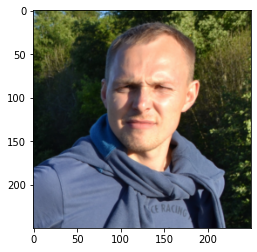

In [111]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)



a_1 = imageio.imread('a_1.jpg', pilmode="RGB")
a_1 = prepare_image(a_1)
plt.imshow(a_1)

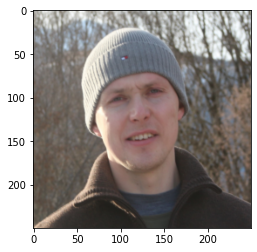

In [112]:
a_2 = imageio.imread('a_2.jpg', pilmode="RGB")
a_2 = prepare_image(a_2)
plt.imshow(a_2)

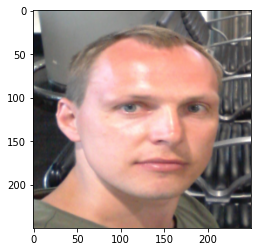

In [113]:
a_3 = imageio.imread('a_3.jpg', pilmode="RGB")
a_3 = prepare_image(a_3)
plt.imshow(a_3)

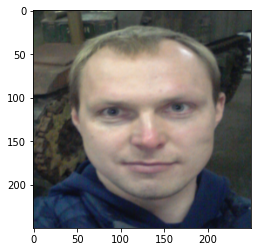

In [114]:
a_4 = imageio.imread('a_4.jpg', pilmode="RGB")
a_4 = prepare_image(a_4)
plt.imshow(a_4)

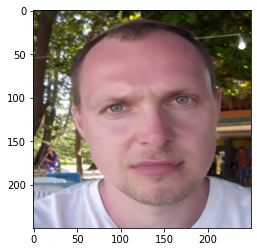

In [115]:
a_5 = imageio.imread('a_5.jpg', pilmode="RGB")
a_5 = prepare_image(a_5)
plt.imshow(a_5)

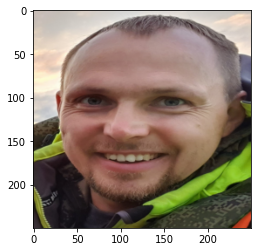

In [116]:
a_6 = imageio.imread('a_6.jpg', pilmode="RGB")
a_6 = prepare_image(a_6)
plt.imshow(a_6)

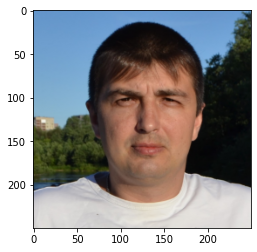

In [122]:
b_1 = imageio.imread('b_1.jpg', pilmode="RGB")
b_1 = prepare_image(b_1)
plt.imshow(b_1)

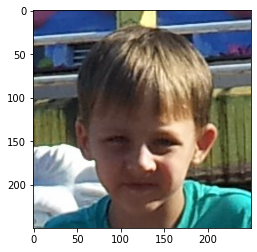

In [117]:
c_1 = imageio.imread('c_1.jpg', pilmode="RGB")
c_1 = prepare_image(c_1)
plt.imshow(c_1)

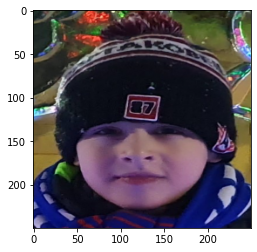

In [118]:
c_2 = imageio.imread('c_2.jpg', pilmode="RGB")
c_2 = prepare_image(c_2)
plt.imshow(c_2)

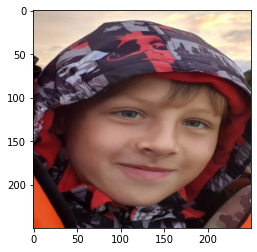

In [119]:
c_3 = imageio.imread('c_3.jpg', pilmode="RGB")
c_3 = prepare_image(c_3)
plt.imshow(c_3)

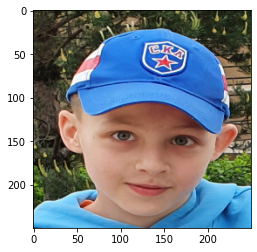

In [120]:
c_4 = imageio.imread('c_4.jpg', pilmode="RGB")
c_4 = prepare_image(c_4)
plt.imshow(c_4)

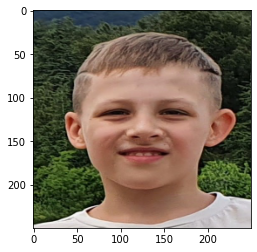

In [121]:
c_5 = imageio.imread('c_5.jpg', pilmode="RGB")
c_5 = prepare_image(c_5)
plt.imshow(c_5)

In [123]:
new_embs = model(np.stack((a_1, a_2, a_3, a_4, a_5, a_6, b_1, c_1, c_2, c_3, c_4, c_5), axis=0))

In [127]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]
emb5 = new_embs[4,:]
emb6 = new_embs[5,:]
emb7 = new_embs[6,:]
emb8 = new_embs[7,:]
emb9 = new_embs[8,:]
emb10 = new_embs[9,:]
emb11 = new_embs[10,:]
emb12 = new_embs[11,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A3 <-> A4: ', diff(emb3, emb4))
print('A4 <-> A5: ', diff(emb4, emb5))
print('A5 <-> A6: ', diff(emb5, emb6))
print('A1 <-> B1: ', diff(emb1, emb7))
print('A3 <-> B1: ', diff(emb3, emb7))
print('A6 <-> B1: ', diff(emb6, emb7))
print('A1 <-> C1: ', diff(emb1, emb8))
print('A1 <-> C2: ', diff(emb1, emb9))
print('A2 <-> C3: ', diff(emb2, emb10))
print('A3 <-> C4: ', diff(emb3, emb11))
print('A4 <-> C5: ', diff(emb4, emb12))
print('C1 <-> C2: ', diff(emb8, emb9))
print('C2<-> C3: ', diff(emb9, emb10))
print('C3 <-> C4: ', diff(emb10, emb11))
print('C4 <-> C5: ', diff(emb11, emb12))
print('C1 <-> B1: ', diff(emb8, emb7))
print('C5 <-> B1: ', diff(emb12, emb7))

A1 <-> A2:  0.0
A2 <-> A3:  0.0
A3 <-> A4:  0.0
A4 <-> A5:  0.0
A5 <-> A6:  0.0
A1 <-> B1:  0.2416130760120088
A3 <-> B1:  0.2416130760120088
A6 <-> B1:  0.2416130760120088
A1 <-> C1:  0.0
A1 <-> C2:  0.0
A2 <-> C3:  0.0
A3 <-> C4:  0.0
A4 <-> C5:  0.0
C1 <-> C2:  0.0
C2<-> C3:  0.0
C3 <-> C4:  0.0
C4 <-> C5:  0.0
C1 <-> B1:  0.2416130760120088
C5 <-> B1:  0.2416130760120088


Вывод: На примере загруженных фотографий видно, что расстояние между эмбеддингами фотографий одного человека практически равно нулю, расстояние между эмбеддингами разных людей примерно 0,24. Алгоритм неплохо обучился разделять классы и фотографии одного человека даже в разном возрасте имеют почти одинаковые эмбеддинги